## Dataset Preparation

Collection of methods used to pull down openlibrary data dump and get cover image embeddings using OpenAI's Clip model


In [ ]:
!pip install -q qdrant-client

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from collections import Counter
import IPython.display
import os
import gc
import time
import sqlite3
import torch

# Google Colab
from google.colab import drive
from google.colab import userdata

# Datasets
from datasets import load_dataset

# Progress bars
from tqdm.auto import tqdm

# Qdrant
from qdrant_client import QdrantClient, models
from qdrant_client.models import PointStruct
from qdrant_client.http.models import Distance, VectorParams

# HuggingFace & LangChain
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Sentence Transformers
from sentence_transformers import SentenceTransformer

# UI Frameworks
import gradio as gr
import libsql_experimental as libsql


### primo test

Ho scaricato un dataset da kaggle di circa 2Mln righe: https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m

Ho unito i sub-dataset in un unico dataset, ho rimosso tutte le righe che non avevano una descrizione del libro e alla fine ho ottenuto un dataset di circa 1.2Mln di righe.


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/semantic book search/dataset_with_description.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171188 entries, 0 to 1171187
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   RatingDist4            1171188 non-null  object 
 1   RatingDist1            1171188 non-null  object 
 2   ISBN                   1168022 non-null  object 
 3   Authors                1171188 non-null  object 
 4   Id                     1171188 non-null  int64  
 5   pagesNumber            424052 non-null   float64
 6   Language               150020 non-null   object 
 7   RatingDist3            1171188 non-null  object 
 8   Name                   1171188 non-null  object 
 9   PublishYear            1171188 non-null  int64  
 10  CountsOfReview         1171188 non-null  int64  
 11  RatingDist5            1171188 non-null  object 
 12  PublishMonth           1171188 non-null  int64  
 13  RatingDist2            1171188 non-null  object 
 14  PublishDay        

In [ ]:
df[df['Authors'].str.contains('Paulo Coelho', na=False)]

,RatingDist4,RatingDist1,ISBN,Authors,Id,pagesNumber,Language,RatingDist3,Name,PublishYear,...,RatingDist5,PublishMonth,RatingDist2,PublishDay,RatingDistTotal,Rating,Publisher,Description,Count of text reviews,PagesNumber
9143,4:25525,1:4248,0060736305,Paulo Coelho,1533442,180.0,eng,3:24663,By the River Piedra I Sat Down and Wept,2004,...,5:21076,1,2:10061,1,total:85573,3.57,HarperTorch,"Since his novel ""The Alchemist"" appeared three...",36.0,NaN
10633,4:56496,1:6451,4042750052,Paulo Coelho,1538405,260.0,jpn,3:44423,ベロニカは死ぬことにした,2003,...,5:45479,25,2:15514,4,total:168363,3.71,角川書店,ベロニカは全てを手にしていた。若さと美しさ、素敵なボーイフレンドたち、堅実な仕事、そして愛情...,0.0,NaN
16423,4:590554,1:99166,8845226573,Paulo Coelho,1558486,182.0,ita,3:399677,L'Alchimista,1995,...,5:770684,1,2:166395,8,total:2026476,3.87,Bompiani,<i>L’Alchimista</i> è la storia di una iniziaz...,192.0,NaN
81538,4:607158,1:101417,8576651858,Paulo Coelho,3187300,NaN,por,3:410596,O Alquimista,2006,...,5:795601,8,2:170503,15,total:2085275,3.88,Planeta,O jovem pastor Santiago tem um sonho que se re...,NaN,192.0
87332,4:49329,1:5566,5955002294,Paulo Coelho,3207719,NaN,rus,3:39552,Одиннадцать минут,2004,...,5:39368,11,2:13920,30,total:147735,3.70,София,С тех пор как знаменитый роман-притча `Алхимик...,NaN,336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073669,4:26092,1:4384,NaN,Paulo Coelho,4566559,NaN,ara,3:25246,على نهر بييدرا هناك جلست فبكيت,2001,...,5:21554,11,2:10362,1,total:87638,3.57,شركة المطبوعات للتوزيع و النشر,"يستأنف باولو كويلو في روايته ""على نهر بييدرا ه...",NaN,205.0
1097654,4:21142,1:3174,8576652811,Paulo Coelho,4676129,NaN,NaN,3:21744,A Bruxa de Portobello,2007,...,5:15990,1,2:8733,1,total:70783,3.54,Planeta,How do we find the courage to always be true t...,NaN,293.0
1151749,4:20662,1:3038,8408068512,Paulo Coelho,1248075,256.0,spa,3:21280,La Bruja De Portobello,2006,...,5:15587,19,2:8523,10,total:69090,3.54,Planeta,Athena es una mujer con un don de la naturalez...,0.0,NaN
1153251,4:20662,1:3038,0061472778,Paulo Coelho,1252044,288.0,eng,3:21281,The Witch of Portobello,2008,...,5:15587,26,2:8523,2,total:69091,3.54,HarperTorch: An Imprint of HarperCollins Publi...,How do we find the courage to always be true t...,27.0,NaN


### secondo test


In [3]:
#caricarlo in un Dataframe è altamente inefficiente, infatti pandas carica tutto il dataframe in RAM. Questo causerà un errore
#perchè il dataset è molto grande (circa 8 gb) e riempirà la memoria
#UN ALTRO DATASET
ds = load_dataset("BrightData/Goodreads-Books")

README.md: 0.00B [00:00, ?B/s]

Goodreads-Books.csv:   0%|          | 0.00/8.29G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
ds['train']

Dataset({
    features: ['url', 'id', 'name', 'author', 'star_rating', 'num_ratings', 'num_reviews', 'summary', 'genres', 'first_published', 'about_author', 'community_reviews', 'kindle_price'],
    num_rows: 6389859
})

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['url', 'id', 'name', 'author', 'star_rating', 'num_ratings', 'num_reviews', 'summary', 'genres', 'first_published', 'about_author', 'community_reviews', 'kindle_price'],
        num_rows: 6389859
    })
})

Puoi ottenere una panoramica delle colonne e dei loro tipi di dato accedendo all'attributo `features` del dataset. La lunghezza del dataset ti darà il numero totale di righe.

In [ ]:
# Visualizza i 'features' del dataset (equivalente a df.info() per tipi di dato e nomi colonne)
print("--- Dataset Features (nomi colonne e tipi di dato) ---")
print(ds['train'].features)

print("\n--- Numero di righe nel dataset ---")
print(f"Numero totale di righe in ds['train']: {len(ds['train'])}")



--- Dataset Features (nomi colonne e tipi di dato) ---
{'url': Value('string'), 'id': Value('string'), 'name': Value('string'), 'author': Value('string'), 'star_rating': Value('float64'), 'num_ratings': Value('int64'), 'num_reviews': Value('float64'), 'summary': Value('string'), 'genres': Value('string'), 'first_published': Value('string'), 'about_author': Value('string'), 'community_reviews': Value('string'), 'kindle_price': Value('string')}

--- Numero di righe nel dataset ---
Numero totale di righe in ds['train']: 6389859


#### Analisi della colonna `genres` utilizzando il dataset `ds`

In [ ]:
def parse_genres(genre_str):
    if pd.isna(genre_str) or genre_str is None:
        return []
    try:
        # Il campo 'genres' potrebbe essere una stringa che rappresenta una lista
        genres_list = ast.literal_eval(genre_str)
        if isinstance(genres_list, list):
            return [g.strip() for g in genres_list if g.strip()]
        else:
            # Se non è una lista dopo literal_eval, considera la stringa originale come un singolo genere
            return [str(genre_str).strip()] if str(genre_str).strip() else []
    except (ValueError, SyntaxError):
        # Se non è un formato literal_eval valido, considera la stringa originale come un singolo genere
        return [str(genre_str).strip()] if str(genre_str).strip() else []

all_genres = []
num_null_genres = 0

# Per un dataset di grandi dimensioni, è più efficiente iterare per batch o usare map/filter
# Qui, iteriamo sulla colonna 'genres' del dataset.
for genre_entry in ds['train']['genres']:
    if genre_entry is None:
        num_null_genres += 1
    else:
        all_genres.extend(parse_genres(str(genre_entry)))

print(f"Numero di valori nulli in 'genres': {num_null_genres}")
print("Esempi di valori in 'genres' dal dataset (prime 10 righe):")
for i in range(min(10, len(ds['train']))):
    print(f"  - {ds['train'][i]['genres']}")

genre_counts = Counter(all_genres)

print("\nGeneri più comuni:")
for genre, count in genre_counts.most_common(10):
    print(f"- {genre}: {count}")

Numero di valori nulli in 'genres': 4652171
Esempi di valori in 'genres' dal dataset (prime 10 righe):
  - None
  - None
  - None
  - ["Music","Nonfiction"]
  - None
  - None
  - None
  - None
  - ["History"]
  - ["Quilting"]

Generi più comuni:
- Nonfiction: 381563
- Fiction: 331983
- Romance: 213708
- History: 175995
- Fantasy: 154589
- Childrens: 122569
- Contemporary: 105486
- Comics: 96552
- Mystery: 96451
- Science Fiction: 79555


#### Analisi della colonna `first_published` utilizzando il dataset `ds`

Numero di valori nulli in 'first_published': 232242
Esempi di valori in 'first_published' dal dataset (prime 10 righe):
  - 11/1/1991
  - 2/1/2000
  - 9/18/2015
  - 10/1/2014
  - 9/5/2015
  - 9/1/2016
  - 9/26/2016
  - 5/12/1977
  - 3/30/2000
  - 4/30/2007

Valori in 'first_published' non convertibili in data (errori di parsing): 12432


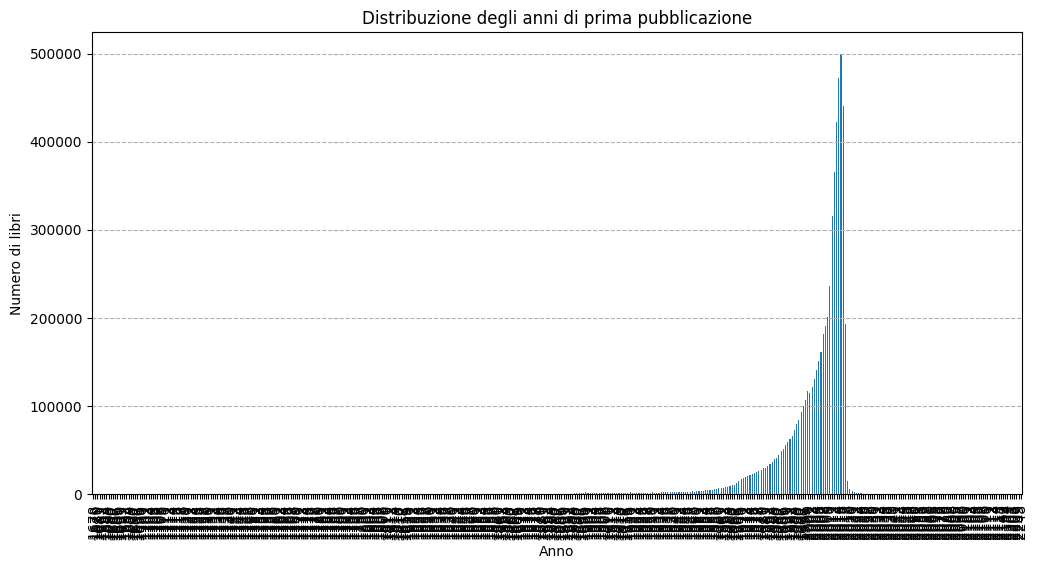

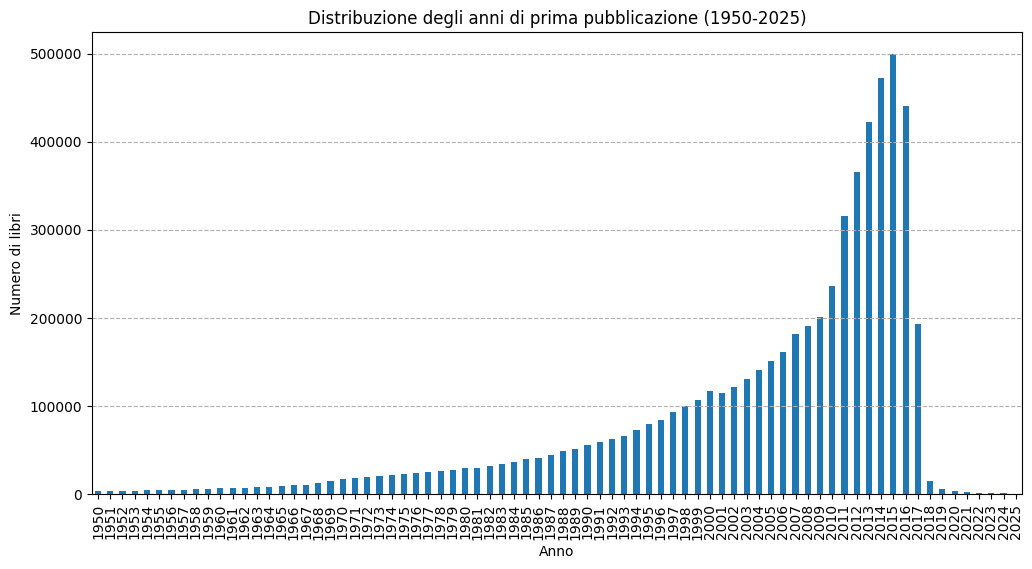

In [9]:
first_published_dates = []
num_null_first_published = 0

for date_entry in ds['train']['first_published']:
    if date_entry is None:
        num_null_first_published += 1
    else:
        first_published_dates.append(str(date_entry)) # Converti in stringa per to_datetime

print(f"Numero di valori nulli in 'first_published': {num_null_first_published}")
print("Esempi di valori in 'first_published' dal dataset (prime 10 righe):")
for i in range(min(10, len(ds['train']))):
    print(f"  - {ds['train'][i]['first_published']}")

# Converti la lista di date in una Series pandas per una più facile gestione e plotting
first_published_series = pd.Series(first_published_dates)

first_published_dt = pd.to_datetime(first_published_series, errors='coerce')

num_parse_errors = first_published_dt.isnull().sum()
print(f"\nValori in 'first_published' non convertibili in data (errori di parsing): {num_parse_errors}")

# Distribuzione degli anni di pubblicazione
years = first_published_dt.dt.year.dropna().astype(int)

if not years.empty:
    plt.figure(figsize=(12, 6))
    years.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribuzione degli anni di prima pubblicazione')
    plt.xlabel('Anno')
    plt.ylabel('Numero di libri')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
    print("Nessun dato valido per l'anno di pubblicazione da visualizzare.")

# Zoom anni pubblicazione 1950-2025
mask_filter = (years >= 1950) & (years <= 2025)
years_zoom = years[mask_filter]

if not years_zoom.empty:
    plt.figure(figsize=(12, 6))
    years_zoom.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribuzione degli anni di prima pubblicazione (1950-2025)')
    plt.xlabel('Anno')
    plt.ylabel('Numero di libri')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
    print("Nessun dato valido per l'anno di pubblicazione da visualizzare.")

In [ ]:
total_rows = len(ds['train'])
non_null_counts = {}

print("Conteggio valori non-null per colonna in ds['train']:")
for column_name in ds['train'].features.keys():
    # Count None values for each column
    null_count = sum(1 for item in ds['train'][column_name] if item is None or pd.isna(item))
    non_null_counts[column_name] = total_rows - null_count

    print(f"- {column_name}: {non_null_counts[column_name]} non-null di {total_rows}")

non_null_df = pd.DataFrame.from_dict(non_null_counts, orient='index', columns=['Non-Null Count'])
non_null_df['Dtype'] = [ds['train'].features[col].dtype for col in non_null_df.index]
non_null_df['Total Rows'] = total_rows
non_null_df['Null Count'] = non_null_df['Total Rows'] - non_null_df['Non-Null Count']

print("\nTabella riassuntiva dei valori non-null:")
display(non_null_df[['Non-Null Count', 'Total Rows', 'Null Count', 'Dtype']])

Conteggio valori non-null per colonna in ds['train']:
- url: 6389859 non-null di 6389859
- id: 6389859 non-null di 6389859
- name: 6389848 non-null di 6389859
- author: 6389799 non-null di 6389859
- star_rating: 6389829 non-null di 6389859
- num_ratings: 6389829 non-null di 6389859
- num_reviews: 3161573 non-null di 6389859
- summary: 5713872 non-null di 6389859
- genres: 1737688 non-null di 6389859
- first_published: 6157617 non-null di 6389859
- about_author: 6389859 non-null di 6389859
- community_reviews: 6389859 non-null di 6389859
- kindle_price: 2252075 non-null di 6389859

Tabella riassuntiva dei valori non-null:


,Non-Null Count,Total Rows,Null Count,Dtype
url,6389859,6389859,0,string
id,6389859,6389859,0,string
name,6389848,6389859,11,string
author,6389799,6389859,60,string
star_rating,6389829,6389859,30,float64
num_ratings,6389829,6389859,30,int64
num_reviews,3161573,6389859,3228286,float64
summary,5713872,6389859,675987,string
genres,1737688,6389859,4652171,string
first_published,6157617,6389859,232242,string


#### fine analisi - puliamo il dataset

In [ ]:
def filter_by_author(example, author_name):
    authors = example.get('author')
    if authors:
        return author_name.lower() in authors.lower()
    return False

def filter_by_author_batched(batch_of_examples, author_name):
    """
    Filtra un batch di esempi in base all'autore
    """

    # Ottiene la lista dei valori della colonna 'author'
    authors_list = batch_of_examples.get('author')
    target_author_lower = author_name.lower()

    # Genera una lista di True/False per l'intero batch
    results = []

    # Itera su ogni elemento autore nel batch
    for author_entry in authors_list:

        is_match = False
        if author_entry is not None:
            author_text = str(author_entry).lower()

            # Controlla se l'autore target è contenuto nel testo dell'autore
            is_match = target_author_lower in author_text

        results.append(is_match)

    # Restituisce una lista di booleani (la maschera di filtro)
    return results

def filter_by_year_and_rating_batched(batch_of_examples, min_year, max_year, min_rating):
    """
    Filtra un batch se:
    1. L'anno ('Anno') è strettamente INFERIORE a max_year.
    2. Il rating ('star_rating') è strettamente MAGGIORE di min_rating.
    """

    years_list = batch_of_examples.get('Anno')
    ratings_list = batch_of_examples.get('star_rating')

    results = []

    # Itera su entrambe le liste simultaneamente
    for year_entry, rating_entry in zip(years_list, ratings_list):
        is_match = False
        y_val = None
        r_val = None

        # Tenta di convertire l'anno solo se non è None
        if year_entry is not None:
            try:
                y_val = int(year_entry)
            except (ValueError, TypeError):
                pass

        # Tenta di convertire il rating solo se non è None
        if rating_entry is not None:
            try:
                r_val = float(rating_entry)
            except (ValueError, TypeError):
                pass

        # Applica la logica di filtro solo se entrambi i valori sono stati convertiti con successo
        if y_val is not None and r_val is not None:
            if y_val >= min_year and y_val <= max_year and r_val > min_rating:
                is_match = True

        results.append(is_match)

    return results

In [ ]:
author_to_filter = 'baricco'
filtered_ds = ds['train'].filter(lambda x: filter_by_author_batched(x, author_to_filter), batched=True, num_proc=6)

filtered_df_from_ds = pd.DataFrame(filtered_ds)
display(filtered_df_from_ds.head())

Filter (num_proc=6):   0%|          | 0/6389859 [00:00<?, ? examples/s]

,url,id,name,author,star_rating,num_ratings,num_reviews,summary,genres,first_published,about_author,community_reviews,kindle_price
0,https://www.goodreads.com/book/show/6478823-ba...,6478823-barnum-cronache-dal-grande-show,Barnum. Cronache dal Grande Show,"[""Alessandro Baricco""]",3.46,406,18.0,Phileas Taylor Barnum è stato il più grande im...,"[""Fiction"",""Italian Literature"",""Journalism""]",1/1/1995,"{""name"":""Alessandro Baricco"",""num_books"":88,""n...","{""1_stars"":{""reviews_num"":9,""reviews_percentag...","""$9.99"""
1,https://www.goodreads.com/book/show/24078121-i...,24078121-i-cinque-migliori-posti-al-mondo-in-c...,I cinque migliori posti al mondo in cui pensar...,"[""Alessandro Baricco""]",3.67,6,NaN,Ho scritto questi cinque reportage – non sapre...,None,5/8/2014,"{""name"":""Alessandro Baricco"",""num_books"":88,""n...","{""1_stars"":{""reviews_num"":0,""reviews_percentag...",None
2,https://www.goodreads.com/book/show/1147181.Next,1147181.Next,Next: Piccolo libro sulla globalizzazione e su...,"[""Alessandro Baricco""]",3.29,743,52.0,Next: la prossima puntata del mondo. Sara la g...,"[""Nonfiction"",""Italian Literature"",""Italy"",""Ph...",2/22/2002,"{""name"":""Alessandro Baricco"",""num_books"":88,""n...","{""1_stars"":{""reviews_num"":29,""reviews_percenta...","""$6.99"""
3,https://www.goodreads.com/book/show/6080265-om...,6080265-omero-iliade,"Omero, Iliade","[""Alessandro Baricco""]",3.69,8638,544.0,L'Iliade di Omero continua a cantare dal fondo...,"[""Fiction"",""Mythology"",""Classics"",""Historical ...",9/1/2004,"{""name"":""Alessandro Baricco"",""num_books"":88,""n...","{""1_stars"":{""reviews_num"":233,""reviews_percent...","""$9.49"""
4,https://www.goodreads.com/book/show/26874528-f...,26874528-fare-il-punto,Fare il punto: Note serie e semiserie sulla pu...,"[""Alessandro Baricco""]",4.00,1,NaN,None,None,1/1/2007,"{""name"":""Alessandro Baricco"",""num_books"":88,""n...","{""1_stars"":{""reviews_num"":0,""reviews_percentag...",None


In [ ]:
# Data preparation
# sulla base delle colonne di interesse, elimino le righe con valori null su quest'ultime
# Definisci la lista delle colonne che vuoi tenere
columns = ["name", "author", "star_rating", "summary", "genres", "first_published"]

ds_ridotto = ds['train'].select_columns(columns)

important_column = ["author", "name", "summary", "first_published"] # quelle che non devono essere null

# La funzione lambda deve restituire True per le righe da MANTENERE
ds_pulito = ds_ridotto.filter(
    lambda x: all(x[col] is not None for col in important_column)
)

# Verifica del risultato
print(f"Righe originali: {len(ds)}")
print(f"Righe dopo selezione colonne: {len(ds_ridotto)}") # Sarà uguale, cambia solo la larghezza
print(f"Righe dopo pulizia null: {len(ds_pulito)}")
print(ds_pulito[0])

Righe originali: 1
Righe dopo selezione colonne: 6389859
Righe dopo pulizia null: 5617537
{'name': 'Horror Film Directors, 1931-1990', 'author': '["Dennis Fischer"]', 'star_rating': 4.29, 'summary': 'An exhaustive study of the major directors of horror films in the past six decades, a genre always popular but often critically snubbed. For each director there is a complete filmography including television work, a career summary, critical assessment, and behind-the-scenes production information. The book covers not only films both old and new, but also directors from Italy, Spain, Australia, Belgium, and elsewhere. Fifty directors are covered in depth, but there is an additional section on the hopeless, the obscure, the promising, and the up-and-coming.', 'genres': None, 'first_published': '11/1/1991'}


In [ ]:
# Analizziamo la distribuzione degli anni di pubblicazione

# --- Mappatura per Estrazione Anno ---
def extract_year(example):
    """
    Funzione per estrarre l'anno dalla data.
    Assumiamo che 'publisher_date' sia una stringa nel formato 'gg/mm/aaaa'.
    """
    date_str = example.get('first_published')
    if date_str and len(date_str) >= 8:
        # L'anno è sempre negli ultimi 4 caratteri con formato gg/mm/aaaa
        year_str = date_str.split('/')[-1]
        try:
            return {'Anno': int(year_str)}
        except ValueError:
            # Gestisce i casi in cui i caratteri estratti non sono numeri validi
            return {'Anno': None}
    return {'Anno': None}

print("Inizio la mappatura del dataset per estrarre l'anno...")

dataset_with_year = ds_pulito.map(
    extract_year
)

print("Mappatura completata.")

Inizio la mappatura del dataset per estrarre l'anno...
Mappatura completata.


In [ ]:
# --- Funzione di Filtro ---
def filter_valid_years_batched(batch):
    """
    Mantiene la riga solo se 'Anno' NON è None.
    """
    years = batch.get('Anno')
    # Restituisce True se l'anno esiste, False se è None
    return [y is not None for y in years]

print(f"Righe totali prima della pulizia: {len(dataset_with_year)}")

# --- Applicazione del Filtro ---
# Questo crea un NUOVO dataset contenente solo le righe valide
dataset_clean = dataset_with_year.filter(filter_valid_years_batched, batched=True)

# Calcolo quante ne abbiamo rimosse
removed_count = len(dataset_with_year) - len(dataset_clean)
print(f"Righe con data non valida rimosse: {removed_count}")
print(f"Righe rimaste nel dataset: {len(dataset_clean)}")

# --- Conteggio sul Dataset Pulito ---
year_counts = Counter()

print("Inizio il conteggio degli anni sul dataset pulito...")

# Ora iteriamo sul dataset che sappiamo essere valido al 100%
for row in dataset_clean:
    year = row.get('Anno')
    year_counts[year] += 1

print("Conteggio completato.")

# Conversione Counter in una Serie Pandas per il plotting
counts_series = pd.Series(year_counts).sort_index()
dataset_with_year = dataset_clean

Righe totali prima della pulizia: 5617537


Filter:   0%|          | 0/5617537 [00:00<?, ? examples/s]

Righe con data non valida rimosse: 2288
Righe rimaste nel dataset: 5615249
Inizio il conteggio degli anni sul dataset pulito...
Conteggio completato.


Filtering years from 1950 to 2025 (inclusive).


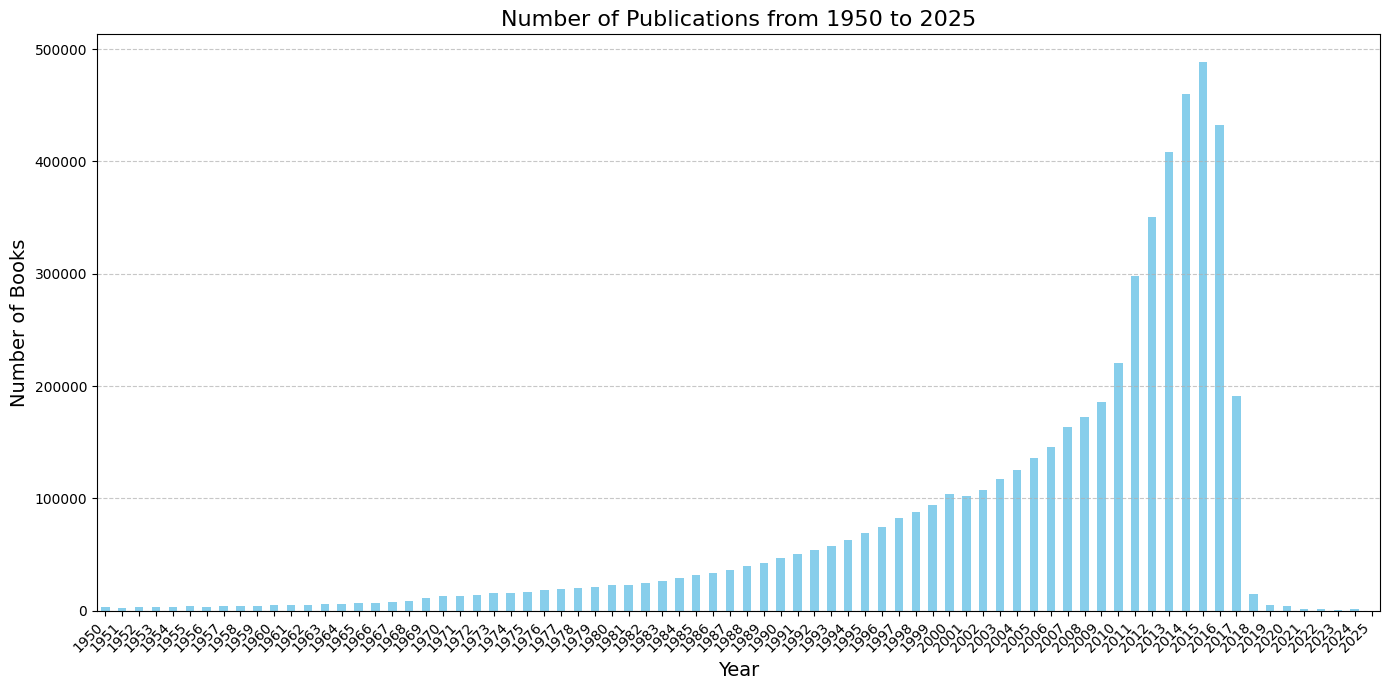

In [ ]:
start_year = 1950
end_year = 2025

print(f"Filtering years from {start_year} to {end_year} (inclusive).")

# Filter the counts_series
filtered_counts_series = counts_series[(counts_series.index >= start_year) & (counts_series.index <= end_year)]

# Plot the filtered series
plt.figure(figsize=(14, 7))
filtered_counts_series.plot(kind='bar', color='skyblue')

plt.title(f'Number of Publications from {start_year} to {end_year}', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Numero di libri', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
min_year=0
max_year=2025
min_rating=3.5
filtered_ds = dataset_with_year.filter(lambda x: filter_by_year_and_rating_batched(x, min_year, max_year, min_rating), batched=True, num_proc=4) #rating>min_rating

# Per visualizzare i risultati, li converto in un DataFrame pandas
filtered_df_from_ds = pd.DataFrame(filtered_ds)
display(filtered_df_from_ds.head())

Filter (num_proc=4):   0%|          | 0/5615249 [00:00<?, ? examples/s]

In [ ]:
len(filtered_df_from_ds)

3649829

#### test generi - NO

Analisi generi (2010-2016) con gestione tipi misti...
Conteggio completato. Generi unici trovati: 264200


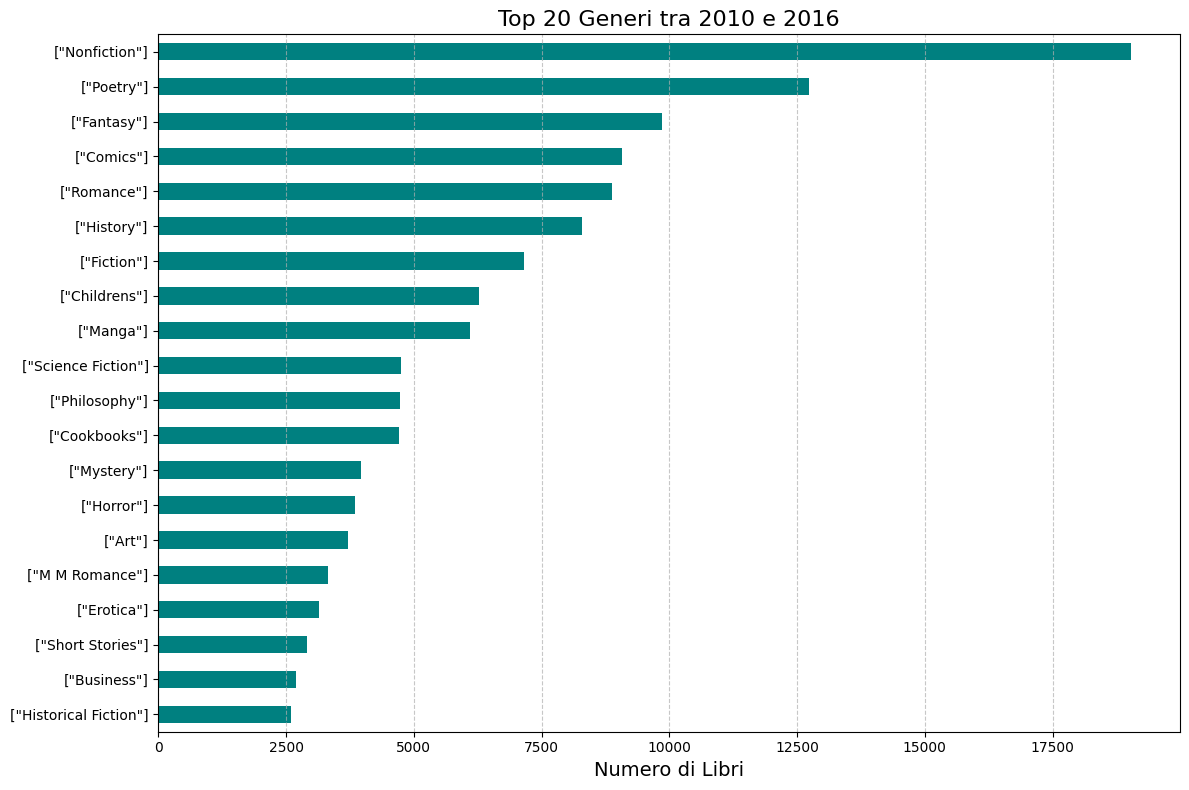

In [ ]:
# --- CONFIGURAZIONE ---
min_year = 2010
max_year = 2016
top_n_genres = 20

print(f"Analisi generi ({min_year}-{max_year}) con gestione tipi misti...")

genre_counts = Counter()
invalid_entries = 0

# --- Conteggio con Normalizzazione ---
for row in dataset_with_year:
    year = row.get('Anno')
    raw_genres = row.get('genres') # Può essere list, str o None

    # Filtro Anno
    if year is not None and min_year <= year <= max_year:

        # Normalizzazione dei Generi
        genres_list_to_count = []

        if raw_genres is None:
            continue # Salta se è None

        elif isinstance(raw_genres, str):
            # CASO STRINGA SINGOLA: "Fiction" -> diventa ["Fiction"]
            genres_list_to_count = [raw_genres]

        elif isinstance(raw_genres, list):
            # CASO LISTA: ["Thriller", "Crime"] -> resta uguale
            genres_list_to_count = raw_genres

        else:
            continue

        # Conteggio effettivo
        for genre in genres_list_to_count:
            # Rimozione spazi vuoti se presenti
            if isinstance(genre, str):
                clean_genre = genre.strip()
                if clean_genre:
                    genre_counts[clean_genre] += 1

print(f"Conteggio completato. Generi unici trovati: {len(genre_counts)}")

# --- Preparazione Dati ---
if len(genre_counts) > 0:
    all_genres_series = pd.Series(genre_counts)
    top_genres_series = all_genres_series.sort_values(ascending=False).head(top_n_genres)

    # --- Plotting ---
    plt.figure(figsize=(12, 8))
    top_genres_series.sort_values().plot(kind='barh', color='teal')

    plt.title(f'Top {top_n_genres} Generi tra {min_year} e {max_year}', fontsize=16)
    plt.xlabel('Numero di Libri', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Nessun genere trovato nel range di anni selezionato.")

#### continua

In [ ]:
filtered_series = counts_series.loc[1985:2025]

print(filtered_series)

total_books_interval = filtered_series.sum()
print(f"Totale libri tra 1985 e 2025: {total_books_interval}")

1985     31397
1986     33248
1987     36441
1988     39716
1989     42550
1990     46730
1991     50552
1992     53866
1993     57384
1994     62831
1995     69252
1996     74550
1997     82368
1998     88208
1999     94308
2000    103622
2001    102007
2002    107762
2003    117315
2004    125649
2005    136007
2006    145939
2007    163639
2008    172701
2009    185872
2010    220862
2011    298058
2012    350696
2013    408577
2014    459694
2015    488772
2016    432227
2017    191370
2018     14823
2019      5268
2020      3807
2021      1920
2022      1365
2023      1028
2024      1237
2025        71
dtype: int64
Totale libri tra 1985 e 2025: 5103689


In [ ]:
# Rimuoviamo dal dataset tutti i libri con rating <=3.5
def filter_low_rating_batched(batch):
    """
    Mantiene solo le righe con star_rating > 3.5.
    Elimina (restituisce False) se:
    - rating <= 3.5
    - rating è None
    - rating non è convertibile in numero
    """

    # Soglia di taglio
    THRESHOLD = 3.5

    ratings_list = batch.get('star_rating')
    results = []

    for r in ratings_list:
        should_keep = False

        if r is not None:
            try:
                # Conversione sicura in float
                val = float(r)

                # LOGICA: Vogliamo eliminare se <= 3.5
                # Quindi manteniamo SOLO SE val > 3.5
                if val > THRESHOLD:
                    should_keep = True

            except (ValueError, TypeError):
                should_keep = False

        results.append(should_keep)

    return results

print(f"Righe prima del filtro: {len(dataset_with_year)}")

dataset_high_rating = dataset_with_year.filter(
    filter_low_rating_batched,
    batched=True,
    batch_size=1000,
    writer_batch_size=1000,
    num_proc=1
)

print(f"Righe dopo il filtro (> 3.5): {len(dataset_high_rating)}")

Righe prima del filtro: 5617537


Filter:   0%|          | 0/5617537 [00:00<?, ? examples/s]

Righe dopo il filtro (> 3.5): 3652475


In [ ]:
dataset_high_rating.to_csv('/content/dataset_high_rating.csv')

Creating CSV from Arrow format:   0%|          | 0/3653 [00:00<?, ?ba/s]

3385702148

In [ ]:
!cp /content/dataset_high_rating.csv '/content/drive/MyDrive/Semantic Book Search/dataset_high_rating.csv'

In [ ]:
author_to_filter = 'carrisi'
filtered_ds = dataset_high_rating.filter(lambda x: filter_by_author_batched(x, author_to_filter), batched=True, num_proc=4)

filtered_df_from_ds = pd.DataFrame(filtered_ds)
display(filtered_df_from_ds)

Filter (num_proc=4):   0%|          | 0/3652475 [00:00<?, ? examples/s]

,name,author,star_rating,summary,genres,first_published,Anno
0,The Whisperer,"[""Donato Carrisi""]",4.18,A gripping literary thriller and smash bestsel...,"[""Thriller"",""Mystery"",""Crime"",""Fiction"",""Myste...",1/1/2009,2009
1,Il maestro delle ombre,"[""Donato Carrisi""]",4.03,Una tempesta senza precedenti si abbatte sulla...,"[""Thriller"",""Crime"",""Mystery"",""Fiction"",""Suspe...",12/2/2016,2016
2,Il Cacciatore del buio,"[""Donato Carrisi""]",4.30,A brutal killer is on the streets of Rome.\r\n...,"[""Thriller"",""Crime"",""Mystery"",""Fiction"",""Suspe...",9/29/2014,2014
3,The Lost Girls of Rome,"[""Donato Carrisi""]",4.03,"A grieving young widow, seeking answers to her...","[""Thriller"",""Mystery"",""Fiction"",""Crime"",""Italy...",9/1/2011,2011
4,L'ipotesi del male,"[""Donato Carrisi""]",4.17,"C’è una sensazione che tutti, prima o poi, abb...","[""Thriller"",""Crime"",""Mystery"",""Fiction"",""Itali...",4/29/2013,2013
5,Tutto quello che dovresti sapere sull'Africa e...,"[""Giuseppe Carrisi""]",4.00,Fin da tempi più remoti l'Africa è stata terra...,None,1/1/2009,2009
6,La donna dei fiori di carta,"[""Donato Carrisi""]",3.72,"Il monte Fumo è una cattedrale di ghiaccio, te...","[""Thriller"",""Fiction"",""Historical Fiction"",""It...",5/3/2012,2012
7,La ragazza nella nebbia,"[""Donato Carrisi""]",3.95,«La giustizia non fa ascolti. La giustizia non...,"[""Thriller"",""Mystery"",""Crime"",""Fiction"",""Itali...",11/23/2015,2015


In [ ]:
dataset_with_year.to_csv('/content/dataset_with_year.csv')

Creating CSV from Arrow format:   0%|          | 0/5618 [00:00<?, ?ba/s]

5094650949

### terzo test - riduciamo drasticamente il dataset

In [1]:
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!cp '/content/drive/MyDrive/Semantic Book Search/dataset_high_rating.csv' '/content/'

In [3]:
df = pd.read_csv('/content/dataset_high_rating.csv')
df

,name,author,star_rating,summary,genres,first_published,Anno
0,"Horror Film Directors, 1931-1990","[""Dennis Fischer""]",4.29,An exhaustive study of the major directors of ...,NaN,11/1/1991,1991.0
1,Zen and the Art of Recording,"[""Mixerman""]",4.19,"In this book, the third in the Zen and the Art...","[""Music"",""Nonfiction""]",10/1/2014,2014.0
2,The Big Book Of Codewords,"[""Parragon Books""]",4.50,500 codeword puzzles in one great book!,NaN,9/5/2015,2015.0
3,Antique Apples from Kilcherman's Christmas Cov...,"[""Phyllis Bye Kilcherman""]",4.00,Antique Apples from Kilcherman’s Christmas Cov...,NaN,9/1/2016,2016.0
4,It's A Wonderful Death: A Fortannis Novel,"[""Derek Beebe""]",4.38,A brave knight breaks her vows to fight agains...,NaN,9/26/2016,2016.0
...,...,...,...,...,...,...,...
3652470,Personal Identity and Buddhist Philosophy: Emp...,"[""Mark Siderits""]",4.15,"Siderits (philosophy, Illinois State U.) uses ...","[""Buddhism"",""Philosophy""]",11/1/2003,2003.0
3652471,25 Cosas que todos los marineros necesitan (Sa...,"[""Lance Gettler""]",3.67,Una cosa que he aprendido es que el océano fav...,NaN,9/9/2013,2013.0
3652472,"Untouchables: Dirty Cops, Bent Justice and Rac...","[""Michael Gillard""]",3.96,'Untouchables' is an integrity test on Scotlan...,"[""Nonfiction"",""Crime"",""True Crime"",""Reference""...",1/1/2004,2004.0
3652473,Famous flyers and their famous flights,"[""Capt. J.J. GRAYSON""]",5.00,This book was converted from its physical edit...,NaN,3/30/2011,2011.0


In [4]:
print(f'Lunghezza iniziale dataset: {len(df)}')
print(f'Numeri libri antecedenti il 1992: {len(df[df["Anno"] < 1992])}')
print(f'Numeri libri >= 1992 con rating < 3.8: {len(df[(df["Anno"] >= 1992) & (df["star_rating"] < 3.8)])}')
print(f"Numeri libri con un summary inferiore a 100 caratteri: {len(df[df['summary'].str.len() < 100])}")

Lunghezza iniziale dataset: 3652475
Numeri libri antecedenti il 1992: 501415
Numeri libri >= 1992 con rating < 3.8: 563057
Numeri libri con un summary inferiore a 100 caratteri: 300457


In [5]:
condition_old = df["Anno"] < 1992
condition_bad_modern = (df["Anno"] >= 1992) & (df["star_rating"] < 3.8)
condition_short_summary = df['summary'].str.len() < 100

rows_to_drop = condition_old | condition_bad_modern | condition_short_summary

df = df[~rows_to_drop].copy()

# Reset indice per evitare buchi nella numerazione
df = df.reset_index(drop=True)

print(f'Lunghezza finale dataset pulito: {len(df)}')

Lunghezza finale dataset pulito: 2437135


In [ ]:
df.to_csv('/content/dataset2.csv')

In [ ]:
!cp '/content/dataset2.csv' '/content/drive/MyDrive/Semantic Book Search/dataset2.csv'

In [6]:
# Cerca l'autore che contenga la string coelho
filtered_df = df[df['author'].str.contains('coelho', case=False)]
filtered_df

,name,author,star_rating,summary,genres,first_published,Anno
10197,Os dialectos romanicos ou neo-latinos na Áfric...,"[""Francisco Adolfo Coelho""]",4.00,Este livro foi convertido de sua ediÃ o fÃ­sic...,NaN,3/25/2011,2011.0
32336,Moderno Pós Moderno,"[""José Teixeira Coelho Netto""]",4.00,Mudar o modo de pensar e sentir poderia ser o ...,NaN,1/1/1995,1995.0
37492,"Curso de Direito da Família, Volume I: introdu...","[""Francisco Pereira Coelho""]",4.00,NOTA À 4.ª EDIÇÃO:\r\nEsgotada a 3.ª edição do...,NaN,1/1/2008,2008.0
44869,Overheard in a Tower Block: Poems by,"[""Joseph Coelho""]",3.92,"Gazing at the stars from five floors up, smell...","[""Poetry"",""Family"",""Middle Grade"",""Childrens"",...",8/29/2017,2017.0
83166,"Prolog by Example: How to Learn, Teach and Use It","[""Helder Coelho""]",5.00,Prolog has a declarative style. A predicate de...,NaN,12/16/2011,2011.0
...,...,...,...,...,...,...,...
2343434,Charlie And The Trains,"[""Layla Coelho""]",4.36,Discover the Amazing Adventures of a Cute Litt...,NaN,4/7/2014,2014.0
2352206,Negros e judeus na praça onze: A história que ...,"[""Beatriz Coelho Silva (Totó)""]",4.00,"No início do século XX, imigrantes negros e ju...",NaN,11/2/2015,2015.0
2393443,Cactus - Botany and Growing,"[""Cláudio Coelho de Paula""]",4.00,Cactus plants have intrigued mankind due to th...,NaN,3/4/2013,2013.0
2393469,Alquimia: Agenda 2015 Paulo Coelho,"[""Paulo Coelho""]",4.40,"RETRACTILADO ORIGINAL, EXCELENTE, DE MÉXICO CO...",NaN,7/22/2014,2014.0


## Qdrant

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Semantic Book Search/dataset2.csv' '/content/'

In [ ]:
df = pd.read_csv('/content/dataset2.csv')
df.head()

,Unnamed: 0,name,author,star_rating,summary,genres,first_published,Anno
0,0,Zen and the Art of Recording,"[""Mixerman""]",4.19,"In this book, the third in the Zen and the Art...","[""Music"",""Nonfiction""]",10/1/2014,2014.0
1,1,Antique Apples from Kilcherman's Christmas Cov...,"[""Phyllis Bye Kilcherman""]",4.00,Antique Apples from Kilcherman’s Christmas Cov...,NaN,9/1/2016,2016.0
2,2,It's A Wonderful Death: A Fortannis Novel,"[""Derek Beebe""]",4.38,A brave knight breaks her vows to fight agains...,NaN,9/26/2016,2016.0
3,3,A New Psychology of Women with Sex & Gender On...,"[""Hilary M. Lips""]",4.00,This text begins with the premise that everyth...,NaN,3/21/2005,2005.0
4,4,Peregrinos del Amianto,"[""Rober Amado""]",5.00,Peregrinos del Amianto es un trabajo periodíst...,NaN,8/27/2015,2015.0


In [ ]:
lengths = df['summary'].str.len()

# Calcola Media e Massimo
mean_length = lengths.mean()
max_length = lengths.max()

print(f"Lunghezza Media: {mean_length:.2f} caratteri")
print(f"Lunghezza Massima: {max_length:.0f} caratteri")

Lunghezza Media: 791.87 caratteri
Lunghezza Massima: 62358 caratteri


La lunghezza media e massima non è molto utile visto il grande divario. Plotto le lunghezze dei summary in base a dei range specifici

Distribuzione lunghezze testi:
           Conteggio  Percentuale %  Cumulativa %
summary                                          
0 - 1k       2589217          70.89         70.89
1k - 2k       899918          24.64         95.53
2k - 5k       161683           4.43         99.95
5k - 10k        1458           0.04         99.99
10k - 20k        164           0.00        100.00
20k - 30k         23           0.00        100.00
30k - 40k          4           0.00        100.00
40k - 50k          4           0.00        100.00
50k - 60k          2           0.00        100.00
> 60k              2           0.00        100.00


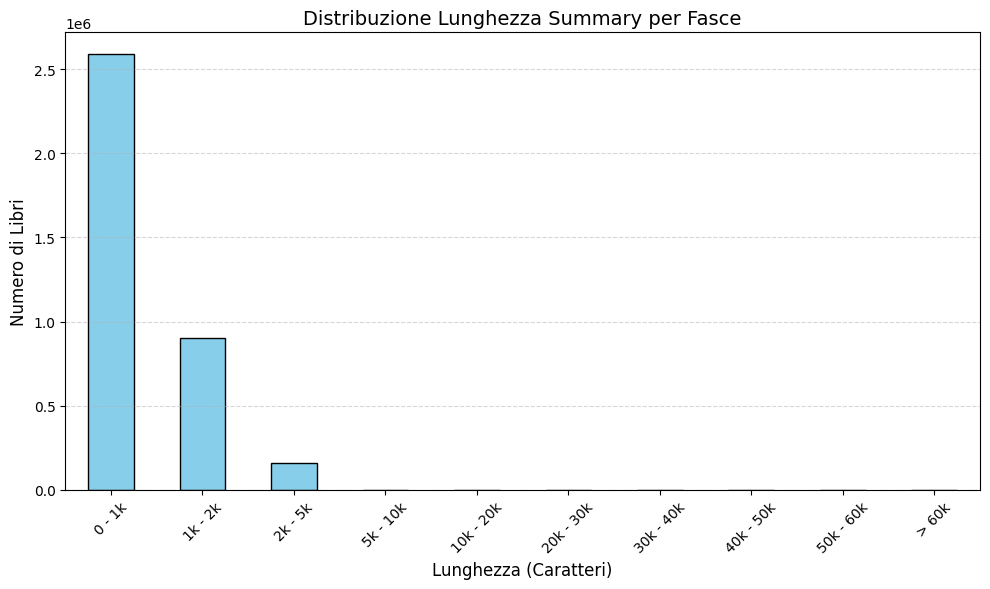

In [ ]:
def analyze_length_thresholds(df, column_name='summary'):
    """
    Divide le lunghezze dei testi in fasce specifiche e calcola statistiche.
    """

    # Calcoliamo le lunghezze
    lengths = df[column_name].str.len().dropna()

    # Definiamo le soglie richieste
    # Aggiungo 0 all'inizio e infinito alla fine per catturare tutto
    bins = [0, 1000, 2000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, np.inf]

    # Creiamo etichette leggibili per il grafico/tabella
    labels = [
        '0 - 1k', '1k - 2k', '2k - 5k', '5k - 10k',
        '10k - 20k', '20k - 30k', '30k - 40k',
        '40k - 50k', '50k - 60k', '> 60k'
    ]

    # Segmentazione (Cutting)
    # pd.cut assegna ogni lunghezza al suo "cestino"
    binned_data = pd.cut(lengths, bins=bins, labels=labels, right=False)

    # Creazione del DataFrame riassuntivo
    stats = pd.DataFrame(binned_data.value_counts(sort=False))
    stats.columns = ['Conteggio']

    # Aggiungiamo Percentuale
    stats['Percentuale %'] = (stats['Conteggio'] / len(lengths)) * 100

    # Percentuale Cumulativa
    # "Fino a questa fascia, quanti libri ho coperto?"
    stats['Cumulativa %'] = stats['Percentuale %'].cumsum()

    return stats

# --- ESECUZIONE ---
distribuzione = analyze_length_thresholds(df, 'summary')

# Formattazione per visualizzare meglio
print("Distribuzione lunghezze testi:")
print(distribuzione.round(2))

plt.figure(figsize=(10, 6))
distribuzione['Conteggio'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuzione Lunghezza Summary per Fasce', fontsize=14)
plt.ylabel('Numero di Libri', fontsize=12)
plt.xlabel('Lunghezza (Caratteri)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Per l'embedding ho scelto il modello `intfloat/multilingual-e5-small` con un embedding-size=384. Pur non essendo addestrato per supportare la tecnica Matryoshka (in cui le informazioni più importanti vengono codificate all'inizio del vettore), empiricamente i vettori di embedding sono **ridondanti** e si è visto, per task semplici, che troncare una piccola parte finale del vettore produce comunque ottimi risultati.

In questo caso ho scelto di rimuovere il 33% dei dati contenuti nella coda del vettore, questo l'ho fatto per ottimizzare le risorse utilizzate dal DB vettoriale senza perdere eccessivamente capacità rappresentativa, sfruttando la naturale ridondanza informativa presente nei modelli di embedding.

Per una questione di efficienza nell'uso delle risorse offerte dal Free Tier di Qdrant, ho deciso di non caricare il payload (i metadati) direttamente su Qdrant ma di utilizzare un DB Relazionale per il retrieve dei metadati (Turso)

Riporto il codice utilizzato in ambiente Kaggle per sfruttare la doppia GPU offerta dalla piattaforma e velocizzare il caricamento su Qdrant.


In [ ]:
%%script false

import torch
import gc
import numpy as np
from tqdm.auto import tqdm
from qdrant_client import models, QdrantClient
from qdrant_client.models import PointStruct
from sentence_transformers import SentenceTransformer

# --- CONFIGURAZIONE ---
print("Caricamento modello E5-Small su MULTI-GPU...")
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
pool = model.start_multi_process_pool() # Attiva le 2 GPU

# Client Qdrant
client = QdrantClient(url=url, api_key=api_key)
COLLECTION_NAME = "books_collection"
VECTOR_SIZE = 256

# --- LOGICA DI RIPRESA ---
start_index = 0

if client.collection_exists(COLLECTION_NAME):
    # Se la collezione esiste, controlliamo quanti elementi ha
    collection_info = client.get_collection(COLLECTION_NAME)
    uploaded_count = collection_info.points_count

    print(f"La collezione '{COLLECTION_NAME}' esiste già.")
    print(f"Elementi già presenti: {uploaded_count}")

    # Impostiamo l'inizio del loop saltando ciò che è già su
    start_index = uploaded_count
else:
    # Se NON esiste, la creiamo da zero
    print(f"La collezione non esiste. Creazione {COLLECTION_NAME}...")
    client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=models.VectorParams(
            size=VECTOR_SIZE,
            distance=models.Distance.COSINE,
            on_disk=True
        ),
        quantization_config=models.ScalarQuantization(
            scalar=models.ScalarQuantizationConfig(
                type=models.ScalarType.INT8,
                always_ram=True
            )
        ),
        hnsw_config=models.HnswConfigDiff(m=16, ef_construct=100),
        optimizers_config=models.OptimizersConfigDiff(
            default_segment_number=2,
            memmap_threshold=20000
        ),
        wal_config=models.WalConfigDiff(wal_capacity_mb=10, wal_segments_ahead=0)
    )
    start_index = 0

# --- UPLOAD INCREMENTALE ---
def resume_upload_continuous(dataframe, start_idx, batch_size=4096):

    total_records = len(dataframe)

    if start_idx >= total_records:
        print("Tutti i dati sono già stati caricati! Nessuna azione necessaria.")
        return

    print(f"Ripresa caricamento dalla riga {start_idx} di {total_records}...")

    # Assicuriamoci che l'indice sia pulito e sequenziale (0, 1, 2...)
    dataframe = dataframe.reset_index(drop=True)

    # La progress bar parte da start_idx
    pbar = tqdm(total=total_records, initial=start_idx, unit="libri")

    # IL CICLO PARTE DA start_idx
    for i in range(start_idx, total_records, batch_size):
        # Prendiamo il batch corrente
        batch_df = dataframe.iloc[i : i + batch_size].copy()
        batch_df = batch_df.replace({np.nan: None})

        try:
            # 1. CREAZIONE TESTO
            text_list = (
                "Author: " + batch_df['author'].astype(str) + "; " +
                "Genres: " + batch_df['genres'].astype(str) + "; " +
                "Summary: " + batch_df['summary'].astype(str).str.slice(0, 2000)
            ).tolist()

            # 2. Embedding MULTI-GPU
            vectors = model.encode(text_list, pool=pool)

            # TAGLIO A 256 DIM
            vectors_cut = vectors[:, :VECTOR_SIZE]

            # 3. Payload Vuoto + ID corrispondente all'indice del DF
            ids = batch_df.index.tolist()
            points = [
                PointStruct(id=uid, vector=v.tolist(), payload={})
                for uid, v in zip(ids, vectors_cut)
            ]

            client.upsert(collection_name=COLLECTION_NAME, points=points)
            pbar.update(len(batch_df))

            del vectors, vectors_cut, text_list, points, batch_df

        except Exception as e:
            print(f"Errore batch {i}: {e}")

    pbar.close()

    print("Stopping multi-process pool...")
    model.stop_multi_process_pool(pool)
    print("\nUpload completato.")

# ESECUZIONE
gc.collect()
torch.cuda.empty_cache()
# Esegue il resume
resume_upload_continuous(df, start_idx=start_index, batch_size=4096)

## TURSO

In [ ]:
!pip install -q libsql-experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 120.4 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- CONFIGURAZIONE ---
TURSO_URL = userdata.get("TURSO_URL")
TURSO_TOKEN = userdata.get("TURSO_TOKEN")
CSV_PATH = "/content/drive/MyDrive/Semantic Book Search/dataset2.csv"
CHUNK_SIZE = 5000

# Connessione
conn = libsql.connect(TURSO_URL, auth_token=TURSO_TOKEN)
print("Connesso a Turso!")

# 2. Creazione Tabella (Schema)
conn.execute("""
    CREATE TABLE IF NOT EXISTS books (
        id INTEGER PRIMARY KEY,
        title TEXT,
        author TEXT,
        year TEXT,
        rating REAL,
        summary TEXT
    )
""")
conn.commit()
print("Tabella pronta.")

# Calcolo totale righe
print("Calcolo righe totali per la progress bar...")
total_rows=len(pd.read_csv(CSV_PATH))
print(f"Righe totali: {total_rows}")

# Caricamento
print("Inizio caricamento su Turso...")

# dtype=str forza tutto a stringa tranne rating, per evitare errori di conversione improvvisi
csv_iterator = pd.read_csv(
    CSV_PATH,
    chunksize=CHUNK_SIZE,
    dtype={"name": str, "author": str, "Anno": str, "summary": str}
)

pbar = tqdm(total=total_rows, unit="libri")

for chunk in csv_iterator:
    chunk['star_rating'] = pd.to_numeric(chunk['star_rating'], errors='coerce').fillna(0)
    chunk = chunk.fillna("N/A")

    data_to_insert = []

    for row in chunk.itertuples(index=True):
        data_to_insert.append((
            row.Index,
            str(row.name),
            str(row.author),
            str(row.Anno),
            row.star_rating,
            str(row.summary)
        ))

    if data_to_insert:
        placeholders = ", ".join([str("(?, ?, ?, ?, ?, ?)")] * len(data_to_insert))
        flat_values = [item for sublist in data_to_insert for item in sublist]

        try:
            conn.execute(
                f"INSERT OR IGNORE INTO books (id, title, author, year, rating, summary) VALUES {placeholders}",
                tuple(flat_values)
            )
            conn.commit()
        except Exception as e:
            print(f"Errore nel chunk corrente: {e}")

    pbar.update(len(chunk))

pbar.close()
conn.close()
print("Finito! Database SQL sincronizzato con Qdrant.")

Connesso a Turso!
Tabella pronta.
Calcolo righe totali per la progress bar...
Righe totali: 2437135
Inizio caricamento su Turso...


  0%|          | 0/2437135 [00:00<?, ?libri/s]

✅ Finito! Database SQL sincronizzato con Qdrant.


In [ ]:
# Test di verifica
conn = libsql.connect(TURSO_URL, auth_token=TURSO_TOKEN)
res = conn.execute("SELECT * FROM books WHERE id = 100").fetchone()
print(f"Libro ID 100 su Turso: {res}")

# Confronta visivamente con il CSV originale
df_test = pd.read_csv(CSV_PATH, nrows=105)
print(f"Libro ID 100 su CSV: \n{df_test.iloc[100]}")

Libro ID 100 su Turso: (100, 'The Interrogation', '["Ethan Jones"]', '2012.0', 3.82, "Captured by terrorists during a rescue operation in Libya, Justin Hall has only his wits and stamina to escape certain death...The Interrogation is a prequel to Canadian Assassin, the book that started it all in the wildly popular Justin Hall spy thriller series.Reviews★★★★★ \xa0“Well written and fast moving!”★★★★★ \xa0“I would love to see this as an entire book -- it's seems to be the kind of novel I could sink into!”★★★★★ \xa0“A great beginning to the series!”★★★★★ \xa0“…a brilliant way to introduce a main character…I can't wait to start Canadian Assassin!”The Justin Hall SeriesThis best-selling series has hundreds of five-star reviews and thousands of sales and downloads. Each book is a clean, self-contained international espionage mission without cliffhangers and can be enjoyed on its own.Scroll up, click, and get lost in the fast-paced, adrenaline-drenched world of Justin Hall now.")
Libro ID 100

## GRADIO (UI)

Per la UI ho utilizzato Gradio e, successivamente, l'ho pubblicato su HuggingFace Space [Semantic Book Search](https://huggingface.co/spaces/ninooo96/SemanticBookSearch)

In [ ]:
import gradio as gr
import os
import libsql_experimental as libsql
from qdrant_client import QdrantClient, models
from sentence_transformers import SentenceTransformer
import time
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0

# --- SETUP MODELLO UNIVERSALE (NLLB) ---
print("Caricamento modello NLLB (Any -> Any)...")
# NLLB-200 Distilled: Ottimo compromesso qualità/peso (600M params)
model_name = "facebook/nllb-200-distilled-600M"

# Carichiamo tokenizzatore e modello
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_trans = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Creiamo una pipeline di traduzione generica
# Nota: NLLB usa codici lingua specifici (es. 'eng_Latn', 'ita_Latn')
translator_pipe = pipeline("translation", model=model_trans, tokenizer=tokenizer, device=-1)

# Mappa semplice per convertire i codici lingua
LANG_CODES = {
    "en": "eng_Latn",
    "it": "ita_Latn"
}

def translate_wrapper(text, target_lang_code):
    """
    Funzione helper per tradurre.
    text: stringa da tradurre
    target_lang_code: 'en' o 'it'
    """
    try:
        nllb_code = LANG_CODES.get(target_lang_code, "eng_Latn")
        # src_lang viene rilevato in automatico o gestito dal modello, 
        # ma dobbiamo forzare il target language.
        output = translator_pipe(text, forced_bos_token_id=tokenizer.lang_code_to_id[nllb_code], max_length=400, truncation=True)
        return output[0]['translation_text']
    except Exception as e:
        print(f"Errore NLLB: {e}")
        return text

# --- SETUP ---
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", device="cpu")

try:
    client = QdrantClient(
        url=userdata.get("QDRANT_URL"),
        api_key=userdata.get("QDRANT_API_KEY")
    )
except Exception as e:
    print(f"Errore Qdrant: {e}")

TURSO_URL = userdata.get("TURSO_URL")
TURSO_TOKEN = userdata.get("TURSO_TOKEN")

def get_turso_conn():
    return libsql.connect(TURSO_URL, auth_token=TURSO_TOKEN)

COLLECTION_NAME = "books_collection"
VECTOR_SIZE = 256

def render_results_from_ids(ids, scores, target_lang="en"):
    """
    target_lang: 'en' (Inglese) o 'it' (Italiano)
    """
    if not ids: return "Nessun risultato trovato."

# --- JAVASCRIPT PER FORZARE DARK MODE ---
JS_FORCE_DARK = """
function() {
    document.body.classList.add('dark');
}
"""

# --- CSS GLOBALE ---
GLOBAL_CSS = """
/* Sfondo pagina e testo */
body, .gradio-container {
    background-color: #0b0f19 !important;
    color: #e5e7eb !important;
}

/* Animazione Spinner */
.loader {
  border: 6px solid #374151;
  border-radius: 50%;
  border-top: 6px solid #3b82f6;
  border-bottom: 6px solid #ef4444;
  width: 40px;
  height: 40px;
  -webkit-animation: spin 1s linear infinite;
  animation: spin 1s linear infinite;
  margin: 0 auto;
}
@keyframes spin { 0% { transform: rotate(0deg); } 100% { transform: rotate(360deg); } }

/* Bottoni Dataset */
#book_cards button {
    background-color: #1f2937 !important;
    color: #e5e7eb !important;
    border: 1px solid #374151 !important;
}
#book_cards button:hover {
    background-color: #374151 !important;
    border-color: #60a5fa !important;
}
#book_cards .text-sm { color: #9ca3af !important; }

/* Stile Card Risultati */
.card-force-dark { color: #e5e7eb !important; }
.card-force-dark h3 { color: #60a5fa !important; margin-top: 0 !important; }
.card-force-dark p, .card-force-dark b, .card-force-dark span { color: #d1d5db !important; }
.card-force-dark summary { color: #fbbf24 !important; }
"""

# HTML dello spinner
LOADING_HTML = """
<div style="display: flex; justify-content: center; align-items: center; height: 100px; width: 100%; flex-direction: column;">
    <div class="loader"></div>
    <p style="margin-top: 10px; color: #666; font-size: 0.9em;">Ricerca libri...</p>
</div>
"""

# --- FUNZIONI DI SUPPORTO ---

def render_results_from_ids(ids, scores, target_lang="en"):
    """Genera l'HTML dai risultati."""
    if not ids: return "Nessun risultato trovato."

    conn = None
    ordered_books = []
    try:
        conn = get_turso_conn()
        placeholders = ", ".join(["?"] * len(ids))
        sql_query = f"SELECT id, title, author, year, rating, summary FROM books WHERE id IN ({placeholders})"
        cursor = conn.execute(sql_query, tuple(ids))
        rows = cursor.fetchall()
        books_map = {row[0]: row for row in rows}

        for uid in ids:
            if uid in books_map:
                ordered_books.append(books_map[uid])
    except Exception as e:
        return f"Errore Database Turso: {str(e)}"
    finally:
        if conn: conn.close()

    html_output = "<div style='font-family: sans-serif; gap: 10px; display: flex; flex-direction: column;'>"
    for row in ordered_books:
        score = scores.get(row[0], 0.0)

        autore_clean = str(row[2]).replace('"', '').replace("[","").replace("]", "")

        original_summary = row[5]
        trama_display = "No summary available."
        lang_label = ""

        # --- LOGICA DI TRADUZIONE INTELLIGENTE ---
        if original_summary and len(original_summary) > 10:
            try:
                # Rileva lingua originale
                try:
                    detected_lang = detect(original_summary)
                except:
                    detected_lang = "unknown"

                # Se la lingua è già quella target, non fare nulla
                if detected_lang == target_lang:
                    trama_display = original_summary
                    lang_label = ""
                
                # Altrimenti traduci
                else:
                    trama_display = translate_wrapper(original_summary, target_lang)
                    lang_label = f"(Translated to {target_lang.upper()})"
            
            except Exception as e:
                trama_display = original_summary
        else:
            trama_display = original_summary
        # -----------------------------------------

        label_trama = "Leggi Trama" if target_lang == 'it' else "Read Summary"

        html_output += f"""
        <div class="card-force-dark" style="border: 1px solid #374151; padding: 15px; border-radius: 8px; box-shadow: 0 4px 6px rgba(0,0,0,0.3); background-color: #1f2937;">
            <h3>{row[1]}</h3>
            <p style="font-size: 0.9em; margin-bottom: 5px;">
                <b>✍️ {autore_clean}</b> | 📅 {row[3]} | ⭐ {row[4]}
            </p>
            <p style="margin-top: 0;">
                <b>🎯 Score:</b> {score:.3f} <span style="font-size: 0.8em; color: #9ca3af;">{lang_label}</span>
            </p>
            <details>
                <summary style="cursor: pointer;">{label_trama}</summary>
                <p style="margin-top: 5px;">{trama_display}</p>
            </details>
        </div>
        """
    html_output += "</div>"
    return html_output

def search_free_text_animated(query_text, max_results, target_lang):
    yield gr.update(visible=True), gr.update(visible=False)
    time.sleep(0.2)

    if not query_text:
        yield gr.update(visible=False), "Inserisci una richiesta!"
        return

    try:
        vec = model.encode(f"{query_text}")[:VECTOR_SIZE]
        hits_response = client.query_points(
            collection_name=COLLECTION_NAME,
            query=vec,
            limit=int(max_results),
            search_params=models.SearchParams(quantization=models.QuantizationSearchParams(rescore=True))
        )
        hits = hits_response.points
        ids = [hit.id for hit in hits]
        scores = {hit.id: hit.score for hit in hits}

        final_html = render_results_from_ids(ids, scores, target_lang)

        yield gr.update(visible=False), gr.update(value=final_html, visible=True)

    except Exception as e:
        yield gr.update(visible=False), f"Errore: {e}"


def find_book_cards_animated(partial_title):
    # FASE 1: Spinner ON, Dataset OFF
    yield gr.update(visible=True), gr.update(visible=False), [], gr.update(value="", visible=False)
    time.sleep(0.3)

    if not partial_title or len(partial_title) < 2:
        yield gr.update(visible=False), gr.update(samples=[], visible=False), [], gr.update(visible=False)
        return

    conn = None
    try:
        conn = get_turso_conn()
        query = f"SELECT id, title, author, year FROM books WHERE title LIKE '%{partial_title}%' LIMIT 10"
        rows = conn.execute(query).fetchall()

        card_data = [[str(row[1]), str(row[2]).replace('"', '').replace("'", "").replace("[","").replace("]",""), str(row[3]).split('.')[0]] for row in rows]
        full_data_state = [{"id": row[0], "title": row[1]} for row in rows]

        # FASE 2: Spinner OFF, Dataset ON
        yield gr.update(visible=False), gr.update(samples=card_data, visible=True), full_data_state, gr.update(visible=False)

    except Exception as e:
        print(f"Error: {e}")
        yield gr.update(visible=False), gr.update(visible=False), [], gr.update(visible=False)
    finally:
        if conn: conn.close()


def on_card_click_animated(selected_index, books_state_list, max_results):
    yield gr.update(visible=True), gr.update(visible=False)
    time.sleep(0.2)

    if selected_index >= len(books_state_list):
        yield gr.update(visible=False), "Errore selezione."
        return

    book_obj = books_state_list[selected_index]
    source_id = book_obj["id"]

    try:
        points = client.retrieve(collection_name=COLLECTION_NAME, ids=[source_id], with_vectors=True)
        if not points:
            yield gr.update(visible=False), "ID non trovato."
            return

        existing_vector = points[0].vector
        hits_response = client.query_points(
            collection_name=COLLECTION_NAME,
            query=existing_vector,
            limit=int(max_results),
            query_filter=models.Filter(must_not=[models.HasIdCondition(has_id=[source_id])]),
            search_params=models.SearchParams(quantization=models.QuantizationSearchParams(rescore=True))
        )
        ids = [hit.id for hit in hits_response.points]
        scores = {hit.id: hit.score for hit in hits_response.points}
        final_html = render_results_from_ids(ids, scores)

        yield gr.update(visible=False), gr.update(value=final_html, visible=True)

    except Exception as e:
        yield gr.update(visible=False), f"Errore Backend: {e}"

def clear_search_tab():
    """Pulisce il Tab Ricerca per Trama quando si passa all'altro."""
    return gr.update(value=""), gr.update(value="", visible=False)

def clear_find_tab():
    """Pulisce il Tab Mi è piaciuto quando si passa all'altro."""
    return (
        gr.update(value=""),           # txt_title
        gr.update(visible=False),      # cards_view (Dataset)
        gr.update(value="", visible=False) # out_results
    )

# --- INTERFACCIA ---
with gr.Blocks(theme=gr.themes.Ocean(), css=GLOBAL_CSS, js=JS_FORCE_DARK) as demo:
    gr.Markdown("# 📚 AI Book Finder")

    books_state = gr.State([])

    with gr.Row():
        num_results = gr.Slider(1, 10, value=5, step=1, label="Quanti consigli vuoi?")
        lang_choice = gr.Dropdown(choices=["en", "it"], value="en", label="Lingua Trama / Summary Language")

    with gr.Tabs() as tabs: 
        
        # TAB 1: Ricerca Libera
        with gr.Tab("🔎 Ricerca per Trama") as tab_trama: # Assegna variabile
            with gr.Row():
                txt_input = gr.Textbox(placeholder="Descrivi la trama, l'atmosfera o le emozioni che cerchi...", show_label=False, scale=4)
                btn_search = gr.Button("Cerca", variant="primary", scale=1)

        # TAB 2: Ricerca per Libro
        with gr.Tab("📖 Mi è piaciuto...") as tab_libro: # Assegna variabile
            with gr.Row():
                txt_title = gr.Textbox(placeholder="Scrivi il titolo, anche parziale", show_label=False, scale=4)
                btn_find = gr.Button("Trova", scale=1)

            loader_cards = gr.HTML(value=LOADING_HTML, visible=False)

            # DATASET
            cards_view = gr.Dataset(
                elem_id="book_cards",
                label="Seleziona il libro corretto:",
                components=[gr.Textbox(visible=False), gr.Textbox(visible=False), gr.Textbox(visible=False)],
                headers=["Titolo", "Autore", "Anno"],
                samples=[],
                visible=False,
                type="index"
            )

    loader_results = gr.HTML(value=LOADING_HTML, visible=False)
    out_results = gr.HTML(label="Consigli", visible=True)

    # --- EVENTI DI RICERCA ---
    btn_search.click(fn=search_free_text_animated, inputs=[txt_input, num_results, lang_choice], outputs=[loader_results, out_results])
    txt_input.submit(fn=search_free_text_animated, inputs=[txt_input, num_results, lang_choice], outputs=[loader_results, out_results])

    btn_find.click(fn=find_book_cards_animated, inputs=[txt_title], outputs=[loader_cards, cards_view, books_state, out_results])
    txt_title.submit(fn=find_book_cards_animated, inputs=[txt_title], outputs=[loader_cards, cards_view, books_state, out_results])

    cards_view.click(
        fn=on_card_click_animated,
        inputs=[cards_view, books_state, num_results],
        outputs=[loader_results, out_results]
    )

    # Quando clicco su "Ricerca per Trama", pulisco il Tab "Mi è piaciuto"
    tab_trama.select(
        fn=clear_find_tab,
        inputs=None,
        outputs=[txt_title, cards_view, out_results]
    )

    # Quando clicco su "Mi è piaciuto", pulisco il Tab "Ricerca per Trama" e i risultati globali
    tab_libro.select(
        fn=clear_search_tab,
        inputs=None,
        outputs=[txt_input, out_results]
    )

print("Avvio Gradio...")
demo.launch(share=True, debug=True)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

/tmp/ipython-input-384205243.py:237: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(), css=GLOBAL_CSS) as demo:
/tmp/ipython-input-384205243.py:237: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(), css=GLOBAL_CSS) as demo:


Avvio Gradio...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f2dbaf117bd846f782.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
